In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications import ResNet50
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sns
from keras.utils import to_categorical
from tensorflow.keras.callbacks import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
# Reading CSV Files
training_data_labels = pd.read_csv('labels.csv')
submission_file = pd.read_csv('sample_submission.csv')
training_data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Computing total records in training and testing files
print("Total number of instances in training data is : {} ".format(training_data_labels.shape[0]))
print("Total number of instances in testing data is  : {} ".format(submission_file.shape[0]))

Total number of instances in training data is : 10222 
Total number of instances in testing data is  : 10357 


In [4]:
# Since, we have to predict only specified classes, therefore, we will remove instances of other classes.
classes_to_predict = ['beagle','chihuahua','doberman','french_bulldog','golden_retriever','malamute','pug','saint_bernard','scottish_deerhound','tibetan_mastiff']
def generate_training_data(classes,training_data):
  ''' Creating the new training data that will 
           only predict specific classes '''
  new_training_data = training_data[training_data["breed"].isin(classes_to_predict)].reset_index()
  new_training_data = new_training_data.drop(columns=['index'])
  return new_training_data

new_training_data = generate_training_data(classes_to_predict,training_data_labels)

In [5]:
new_training_data.head()

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


In [6]:
# Displying records in new Training Data
print("The new training dataset has {} rows and {} columns.".format(new_training_data.shape[0],new_training_data.shape[1]))

The new training dataset has 841 rows and 2 columns.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


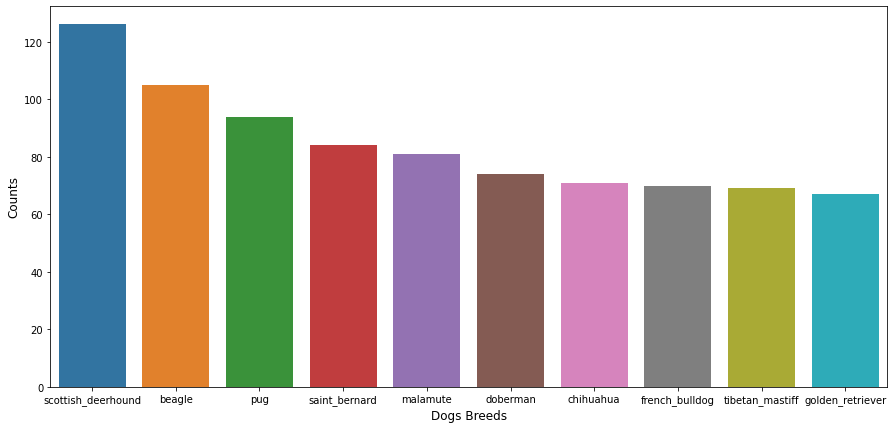

In [7]:
# Visualizing samples in different categories in training data
labels_count = new_training_data['breed'].value_counts()
plt.figure(figsize=(15,7))
sns.barplot(labels_count.index,labels_count.values)
plt.xticks(rotation='horizontal')
plt.xlabel('Dogs Breeds',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.show()

In [8]:
# Path to Images in training and testing Data
TRAIN_PATH = 'train/'
TEST_PATH  = 'test/'

In [9]:
# preprocessing image
IMAGE_SIZE = 150
def read_img(img_path):
  ''' Reading and Resizing Images'''
  img_read = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img_resize = cv2.resize(img_read,(IMAGE_SIZE,IMAGE_SIZE))
  return img_resize

In [10]:
# Standardizing the Image
def standardize(data):
  ''' Standardizing Images'''
  mean_image = np.mean(data,axis=0)
  std_img = np.std(data,axis=0)
  data = (data-mean_image) / std_img
  return data

In [11]:
# Preparing training data
train_img = []
for img_name in tqdm(new_training_data['id'].values):
    train_img.append(read_img(TRAIN_PATH+img_name+".jpg"))
X = np.array(train_img,np.float32)/255.0
X = standardize(X)

100%|██████████| 841/841 [00:02<00:00, 331.00it/s]


In [12]:
# Preparing testing data
test_img = []
for img_name in tqdm(submission_file['id'].values):
    test_img.append(read_img(TEST_PATH+img_name+".jpg"))
X_test = np.array(test_img,np.float32)/255.0
X_test = standardize(X_test)

100%|██████████| 10357/10357 [00:27<00:00, 379.68it/s]


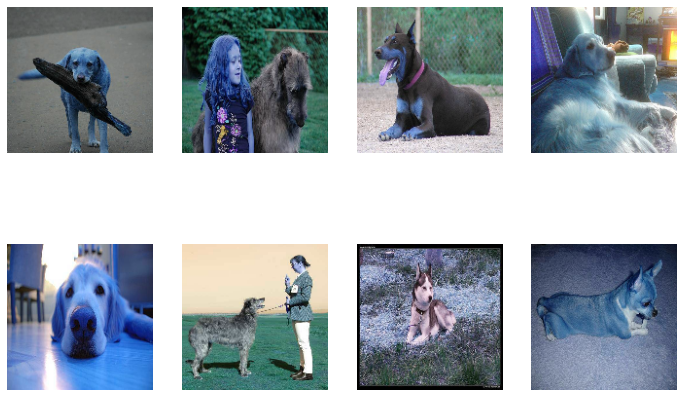

In [ ]:
# Visualizing training images
plt.figure(figsize=(12,8))
for i in range(0,8,1):
  plt.subplot(2,4,i+1)
  plt.axis("off")
  plt.imshow(train_img[i])

In [15]:
# Encoding target dogs breeds
num_classes = 10
def generate_target_values(training_data,classes):
  ''' One-Hot- Encoding Target values'''
  label_list = training_data["breed"].tolist()
  label_numeric = {k:v for v,k in enumerate(set(label_list))}
  target_values = [label_numeric[k] for k in label_list]
  target_values = np.array(target_values)
  target_values = to_categorical(target_values,num_classes=num_classes)
  return target_values

y = generate_target_values(new_training_data,num_classes)

In [39]:
# Splitting the data into train and validation set
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)
x_train,x_valid,y_train,y_valid = train_test_split(X_train,Y_train,test_size=0.1,random_state=1,stratify=Y_train)

In [18]:
# Defining base model
base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))   

94773248/94765736 [==============================] - 1s 0us/step


In [40]:
from tensorflow.keras.layers import BatchNormalization
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dropout(0.4))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dropout(0.4))
add_model.add(Dense(num_classes,activation='softmax'))
model = Model(inputs=base_model.input,outputs = add_model(base_model.output))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [41]:
# Compiling Model
optimizer = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [42]:
# Defining callback Methods
n_epoch = 55

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                             verbose=1, mode='auto')

In [43]:
# Data Augumentation
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(x_train)

In [44]:
# Fitting the model
batch_size = 64
history = model.fit(train_datagen.flow(x_train,y_train,batch_size=10),
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_valid,y_valid),steps_per_epoch=batch_size
                   )

Epoch 1/55
64/64 [==============================] - 12s 103ms/step - loss: 3.7372 - accuracy: 0.1183 - val_loss: 1.6283 - val_accuracy: 0.4474
Epoch 2/55
64/64 [==============================] - 6s 88ms/step - loss: 2.4330 - accuracy: 0.2305 - val_loss: 1.1735 - val_accuracy: 0.6579
Epoch 3/55
64/64 [==============================] - 6s 90ms/step - loss: 1.9037 - accuracy: 0.3569 - val_loss: 0.9129 - val_accuracy: 0.7368
Epoch 4/55
64/64 [==============================] - 6s 90ms/step - loss: 1.6923 - accuracy: 0.4858 - val_loss: 0.7879 - val_accuracy: 0.7500
Epoch 5/55
64/64 [==============================] - 6s 90ms/step - loss: 1.3934 - accuracy: 0.5163 - val_loss: 0.6411 - val_accuracy: 0.7895
Epoch 6/55
64/64 [==============================] - 6s 90ms/step - loss: 1.2648 - accuracy: 0.5848 - val_loss: 0.6330 - val_accuracy: 0.7763
Epoch 7/55
64/64 [==============================] - 6s 90ms/step - loss: 1.1020 - accuracy: 0.6187 - val_loss: 0.5895 - val_accuracy: 0.8026
Epoch 8/55


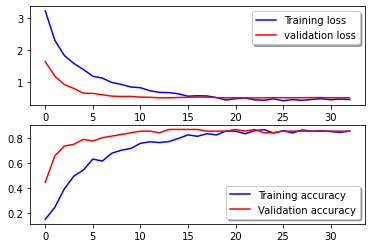

In [45]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [46]:
# Predictions on testing data created from training data
predictions_model = model.predict(x_test)

In [47]:
#Unrolling Predictions
def generate_testing_labels(predictions,training_data):
  ''' Generate One-Hot Encoding Vectors for Testing Labels '''
  label_list = training_data["breed"].tolist()
  label_numeric = {k:v for v,k in enumerate(set(label_list))}
  predictions_model_max = np.argmax(predictions,axis=1)
  predictions_onehot = to_categorical(predictions_model_max)
  return predictions_onehot

predictions_onehot = generate_testing_labels(predictions_model,training_data_labels)


In [48]:
# Classification Report
cr = classification_report(y_test,predictions_onehot)

In [49]:
print(cr)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      1.00      1.00         8
           2       1.00      0.86      0.92         7
           3       1.00      0.92      0.96        13
           4       0.91      0.91      0.91        11
           5       0.86      0.86      0.86         7
           6       0.75      0.90      0.82        10
           7       1.00      0.75      0.86         8
           8       0.78      1.00      0.88         7
           9       0.83      0.71      0.77         7

   micro avg       0.89      0.89      0.89        85
   macro avg       0.90      0.89      0.89        85
weighted avg       0.90      0.89      0.89        85
 samples avg       0.89      0.89      0.89        85



In [50]:
# ROC - AUC Score
score = roc_auc_score(y_test,predictions_onehot)
print("The ROC-AUC Score is : {} ".format(score))

The ROC-AUC Score is : 0.9396561591561591 


In [51]:
# Accuracy Score
acuracy_score = accuracy_score(y_test,predictions_onehot)
print("The Accuracy Score is : {} ".format(acuracy_score))

The Accuracy Score is : 0.8941176470588236 


In [54]:
# F1- Score
f1_score = f1_score(y_test,predictions_onehot,average='weighted')
print("The F1-Score is : {} ".format(f1_score))

The F1-Score is : 0.8932276470588194 


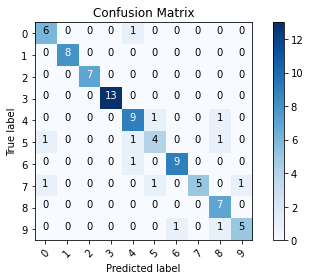

In [57]:
#Plotting Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test_labels, predictions_model_max,labels=[0,1,2,3,4,5,6,7,8,9])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion Matrix')

In [77]:
# Saving the model for Future Inferences
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [58]:
# Converting the data in y_test back to labels
y_test_labels = np.argmax(y_test,axis=1)
y_test_labels

array([4, 5, 7, 2, 9, 6, 3, 3, 4, 3, 2, 2, 7, 9, 0, 1, 8, 7, 3, 2, 5, 9,
       6, 4, 3, 4, 0, 4, 4, 5, 4, 5, 9, 1, 2, 7, 4, 4, 6, 8, 1, 3, 9, 5,
       2, 1, 7, 3, 6, 4, 5, 0, 9, 0, 1, 3, 8, 1, 0, 5, 3, 4, 8, 6, 1, 0,
       8, 8, 1, 9, 7, 3, 6, 6, 8, 3, 6, 7, 3, 0, 2, 6, 6, 3, 7])

In [59]:
# Making Final Predictions on test set
final_predictions = model.predict(X_test)
final_predictions

array([[1.06e-01, 6.95e-03, 1.07e-02, ..., 1.55e-02, 2.50e-02, 5.69e-02],
       [1.17e-01, 6.97e-03, 1.15e-02, ..., 2.13e-02, 8.60e-03, 1.38e-02],
       [1.27e-02, 2.62e-04, 1.61e-03, ..., 3.77e-03, 3.94e-03, 9.96e-04],
       ...,
       [3.23e-02, 8.68e-03, 2.25e-02, ..., 1.64e-02, 6.47e-01, 2.66e-02],
       [1.25e-02, 3.08e-03, 1.65e-03, ..., 1.34e-02, 4.06e-01, 6.48e-02],
       [1.32e-02, 7.45e-03, 1.07e-02, ..., 1.17e-02, 1.17e-01, 1.39e-02]],
      dtype=float32)

In [60]:
submission_file.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [61]:
# Preparing test dataframe in the required format
prediction_file = pd.DataFrame(submission_file["id"])
predictions_final = pd.DataFrame(final_predictions,columns=classes_to_predict)
test_predictions = pd.concat([prediction_file,predictions_final],axis=1)

In [62]:
test_predictions.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,0.105665,0.006951,0.010695,0.020455,0.054642,0.292960,0.411319,0.015494,0.024961,0.056858
1,00102ee9d8eb90812350685311fe5890,0.116764,0.006967,0.011506,0.008135,0.018877,0.464038,0.330040,0.021326,0.008597,0.013751
2,0012a730dfa437f5f3613fb75efcd4ce,0.012672,0.000262,0.001611,0.953039,0.002407,0.002568,0.018732,0.003771,0.003942,0.000996
3,001510bc8570bbeee98c8d80c8a95ec1,0.016725,0.001501,0.019060,0.128460,0.237051,0.510788,0.078699,0.002736,0.004044,0.000936
4,001a5f3114548acdefa3d4da05474c2e,0.003119,0.010743,0.004710,0.554700,0.004359,0.015244,0.188387,0.010586,0.173830,0.034321
